In [1]:
!pip install unrar torchinfo numba gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.2 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=695324725eeacaa930de05332cc909ae29e1eed73799121ea07cea26c1585cde
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [2]:
import torch
from torchinfo import summary
from torchtext.utils import download_from_url
import subprocess
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import models
from tqdm.auto import tqdm
import os
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import math
import torchvision

In [3]:
SEED = 1337
base_dir = os.getcwd()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Source: https://figshare.com/s/37ec464af8e81ae6ebbf
rawImage = 'https://figshare.com/ndownloader/files/5466590?private_link=37ec464af8e81ae6ebbf'
annotationsByMD = 'https://figshare.com/ndownloader/files/5466581?private_link=37ec464af8e81ae6ebbf'
evaluationCode = 'https://figshare.com/ndownloader/files/5466584?private_link=37ec464af8e81ae6ebbf'

# [[fileName, directDownloadLink]..]
# 'nofolder' = extracts directly to /content/data/ instead of creating a folder with the given name
files = [['nofolder', rawImage],
         ['Annotations', annotationsByMD],
         ['nofolder', evaluationCode]]

In [5]:
def download_files(files):
  subprocess.run(['mkdir', '{}/data'.format(base_dir)])
  extractedDirs = []
  for [fileName, link] in files:
    extractedDirs.append(download_file(link, fileName))
  subprocess.run(['rm', '-rf', '/content/.data'])
  return extractedDirs

In [6]:
def download_processed_data():
  subprocess.run(['mkdir', '{}/data'.format(base_dir)])
  url = 'https://drive.google.com/file/d/1gTmP4u4CGPKjEC0OFcx6TsIgtdC2U33Y/view?usp=sharing'
  subprocess.run(['gdown', '--fuzzy', url])
  subprocess.run(['unzip', '{}/process_data.zip'.format(base_dir), '-d', '{}/data/processed_data'.format(base_dir)])
  subprocess.run(['rm', '{}/process_data.zip'.format(base_dir)])
  return '{}/data/processed_data'.format(base_dir)

In [7]:
download_processed_data()

Downloading...
From (uriginal): https://drive.google.com/uc?id=1gTmP4u4CGPKjEC0OFcx6TsIgtdC2U33Y
From (redirected): https://drive.google.com/uc?id=1gTmP4u4CGPKjEC0OFcx6TsIgtdC2U33Y&confirm=t&uuid=de44b385-7d0e-4865-a118-213f68539ba4
To: /kaggle/working/process_data.zip
100%|██████████| 122M/122M [00:01<00:00, 71.7MB/s] 


Archive:  /kaggle/working/process_data.zip
   creating: /kaggle/working/data/processed_data/cepha/
  inflating: /kaggle/working/data/processed_data/cepha/001.jpg  
  inflating: /kaggle/working/data/processed_data/cepha/002.jpg  
  inflating: /kaggle/working/data/processed_data/cepha/003.jpg  
  inflating: /kaggle/working/data/processed_data/cepha/004.jpg  
  inflating: /kaggle/working/data/processed_data/cepha/005.jpg  
  inflating: /kaggle/working/data/processed_data/cepha/006.jpg  
  inflating: /kaggle/working/data/processed_data/cepha/007.jpg  
  inflating: /kaggle/working/data/processed_data/cepha/008.jpg  
  inflating: /kaggle/working/data/processed_data/cepha/009.jpg  
  inflating: /kaggle/working/data/processed_data/cepha/010.jpg  
  inflating: /kaggle/working/data/processed_data/cepha/011.jpg  
  inflating: /kaggle/working/data/processed_data/cepha/012.jpg  
  inflating: /kaggle/working/data/processed_data/cepha/013.jpg  
  inflating: /kaggle/working/data/processed_data/cepha/0

'/kaggle/working/data/processed_data'

In [8]:
class LandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, landmarksNum=19, asArray=False):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.landmarkNum = landmarksNum
        self.asArray = asArray

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = Image.open(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:self.landmarkNum * 2 + 1].values.astype('float')
        landmarks = landmarks.reshape(-1, 2)
        w, h = image.size

        if self.asArray:
          landmarks_mask = torch.zeros(size=(19, 1, h, w))
        else:
          landmarks_mask = torch.zeros(size=(1, h, w))

        marker_size = 0
        for i, coordinate in enumerate(landmarks):
          x, y = coordinate
          x, y = int(x), int(y)
          if self.asArray:
            if marker_size > 0:
                landmarks_mask[i, 0, y-marker_size:y+marker_size, x-marker_size:x+marker_size] = 1
            else:
                landmarks_mask[i, 0, y, x] = 1
          else:
            if marker_size > 0:
                landmarks_mask[0, y-marker_size:y+marker_size, x-marker_size:x+marker_size] = 1
            else:
                landmarks_mask[0, y, x] = 1    

        sample = {'image': image, 'landmarks': landmarks, 'mask': landmarks_mask}
        if self.transform:
            sample = self.transform(sample)

        return sample

In [199]:
class Rescale(object):
  """Rescale the image in a sample to a given size.

  Args:
      output_size (tuple or int): Desired output size. If tuple, output is
          matched to output_size. If int, smaller of image edges is matched
          to output_size keeping aspect ratio the same.
  """

  def __init__(self, output_size, asArray=False):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size
    self.asArray = asArray

  def __call__(self, data):
    image, landmarks, mask = data['image'], data['landmarks'], data['mask']
    h, w = image.size

    if isinstance(self.output_size, int):
        if h > w:
            new_h, new_w = self.output_size * h / w, self.output_size
        else:
            new_h, new_w = self.output_size, self.output_size * w / h
    else:
        new_h, new_w = self.output_size

    new_w, new_h = int(new_w), int(new_h)

    img = image.resize(size=(new_w, new_h))

    resize = transforms.Resize(size=(new_h, new_w), antialias=True)
    mask = resize(mask)

    # landmarks are (x, y) so we do 1/(w-1) and 1/(h-1) as w = x-axis, h = y-axis
    landmarks = landmarks * [1 / (w - 1), 1 / (h - 1)]

    return {'image': img, 'landmarks': landmarks, 'mask': mask}

In [200]:
class ToGrayscale(object):
  """Converts the image to grayscale."""

  def __call__(self, sample):
    image, landmarks = sample['image'], sample['landmarks']
    grayscale = transforms.Grayscale()(image)

    return {'image': grayscale, 'landmarks': landmarks}

In [201]:
class ToTensor(object):
  """Convert ndarrays in sample to Tensors."""

  def __init__(self):
    self.PILToTensor = transforms.PILToTensor()

  def __call__(self, sample):
    # image, tlandmarks, targetMaps = sample['image'], sample['landmarks'], sample['targetMaps']
    image, tlandmarks, mask = sample['image'], sample['landmarks'], sample['mask']
    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    tensorImage = self.PILToTensor(image)
    landmarks = np.zeros(tlandmarks.shape)
    landmarks[:, 0], landmarks[:, 1] = tlandmarks[:, 1], tlandmarks[:, 0]

    return {'image': tensorImage/255,
            'landmarks': torch.from_numpy(landmarks).float(),
            'mask': mask}
      # 'targetMaps': [torch.from_numpy(targetMap).float() for targetMap in targetMaps]}

In [202]:
root_image_dir = '{}/data/processed_data/cepha'.format(base_dir)
train_csv_dir = '{}/data/processed_data/cepha_train.csv'.format(base_dir)
val_csv_dir = '{}/data/processed_data/cepha_val.csv'.format(base_dir)
test_csv_dir = '{}/data/processed_data/cepha_test.csv'.format(base_dir)

# train_shape = (256, 256)
train_shape = (745, 600)
# train_shape = (2400, 1935)

In [203]:
img_transforms = transforms.Compose([
    Rescale(train_shape),
    ToTensor(),
    ToGrayscale()
])

In [204]:
train_dataset = LandmarksDataset(csv_file=train_csv_dir, root_dir=root_image_dir, transform=img_transforms)
val_dataset = LandmarksDataset(csv_file=val_csv_dir, root_dir=root_image_dir, transform=img_transforms)
test_dataset = LandmarksDataset(csv_file=test_csv_dir, root_dir=root_image_dir, transform=img_transforms)

In [205]:
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [206]:
def preload(dataloader):
  # saves time by applying all the transformations and batching them instead of doing them at the time of training
  preloaded_batches = []
  for batch in dataloader:
    preloaded_batches.append(batch)
  return preloaded_batches

In [207]:
preloaded_train_data = preload(train_dataloader)
preloaded_val_data = preload(val_dataloader)

In [208]:
def batch_info(preloaded_data):
  print(f"# of batches: {len(preloaded_data)}")
  print(f"Batch image shape: {preloaded_data[0]['image'].shape}")
  print(f"Batch landmarks shape: {preloaded_data[0]['landmarks'].shape}")
  total = 0
  for batch in preloaded_data:
    total += batch['image'].shape[0]
  print(f"Total # of image-landmark pairs: {total}")

batch_info(preloaded_train_data)

# of batches: 38
Batch image shape: torch.Size([4, 1, 745, 600])
Batch landmarks shape: torch.Size([4, 19, 2])
Total # of image-landmark pairs: 150


In [209]:
def save_model(model, optimizer, epoch, save_path):
  """Saves a PyTorch model, optimizer, and epoch number to a file.

  Args:
    model: The PyTorch model to save.
    optimizer: The PyTorch optimizer to save.
    epoch: The current epoch number.
    save_path: The path to the file where the model, optimizer, and epoch number will be saved.
  """

  torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch
  }, save_path)

def load_model(model, optimizer, load_path):
  """Loads a PyTorch model, optimizer, and epoch number from a file.

  Args:
    model: The PyTorch model to load.
    optimizer: The PyTorch optimizer to load.
    load_path: The path to the file where the model, optimizer, and epoch number were saved.
  """

  checkpoint = torch.load(load_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']

  return epoch

In [210]:
def train(model, train_data, val_data, criterion, optimizer, epochs, batch_size=batch_size):

  for i in range(epochs):
    print(f"epoch-{i+1}/{epochs}")
    # training
    model.train()
    train_loss = 0.0

    pbar = tqdm(total=len(train_data)*batch_size)
    count = 0
    for batch in train_data:
      images, landmarks = batch['image'].to(device), batch['landmarks'].to(device)

      # clear previous gradients
      optimizer.zero_grad()
      # forward pass
      images = images.float()
      output = model(images)
      # loss calculation
      loss = criterion(output, landmarks)
      # back propagation
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      count += 1
      pbar.update(batch_size)
    
#       pbar.set_description(f"Training loss: {train_loss/(batch_size*count)}")
        
    pbar.close()

    train_loss /= len(train_data)

#     pbar.set_description(f"Training loss: {train_loss}")
    print(f"Training loss: {train_loss}")

    # validation
    model.eval()
    val_loss = 0.0

    # pbar = tqdm(total=len(val_data)*batch_size)
    with torch.no_grad():
      for batch in val_data:
        images, landmarks = batch['image'].to(device), batch['landmarks'].to(device)
        # forward pass
        images = images.float()
        output = model(images)
        # loss calculation
        loss = criterion(output, landmarks)
        val_loss += loss.item()
        # pbar.update(batch_size)
    # pbar.close()

    val_loss /= len(val_data)

    print(f"Val loss: {val_loss}")

In [211]:
class CNML(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNML, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, (3, 3), padding='same')
        self.pool = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels, (3, 3), padding='same')
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        
        return x


class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6

class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)

class CoordAtt(nn.Module):
    def __init__(self, inp, oup, reduction=32):
        super(CoordAtt, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))

        mip = max(8, inp // reduction)

        self.conv1 = nn.Conv2d(inp, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = h_swish()
        
        self.conv_h = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        

    def forward(self, x):
        identity = x
        
        n,c,h,w = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)

        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y) 
        
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)

        a_h = self.conv_h(x_h).sigmoid()
        a_w = self.conv_w(x_w).sigmoid()

        out = identity * a_w * a_h

        return out
    
class SimplerModel(nn.Module):
  def __init__(self, in_channels = 1, coordinates = 19):
    super(SimplerModel, self).__init__()
    
    self.cnml1 = CNML(in_channels, 64)
    self.globalAvgPool = nn.AdaptiveAvgPool2d((16, 16))    
    self.attn = CoordAtt(64, 64)
#     self.attn = torchvision.ops.SqueezeExcitation(64, 64)
    self.cnml2 = CNML(64, 256)
    self.flatten = nn.Flatten()
    self.dropout = nn.Dropout(0.3)
    
    self.fc1 = nn.Linear(in_features=4096, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=coordinates*2)
    
    self.sigmoid = nn.Sigmoid()
    
  def forward(self, x):
    x = self.cnml1(x)
    x = self.globalAvgPool(x)
    
    attn = self.attn(x)
    
    x = self.cnml2(x + attn)
    
    
    x = self.flatten(x)
    x = self.dropout(x)
    
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.fc3(x)
    
#     x = self.sigmoid(x)
    
    return x

In [212]:
def coord_loss(y_pred, y_true):
    mse = F.mse_loss
    b = y_pred.shape[0]
    y_pred = y_pred.reshape(b, -1, 2)
    
    if(len(y_true.shape) == 2):
        y_true = y_true.unsqueeze(0)
    
    mse_coord = mse(y_pred, y_true, reduction='none') # MSE of individual coordinates
    mse_ratio = mse_coord/y_true
    mse = torch.sum(mse_ratio, dim=2)
#     euclidean_distance = torch.sqrt(mse)
    total_loss = torch.mean(mse)
    
    return total_loss

In [213]:
model = SimplerModel()
model = nn.DataParallel(model)
model = model.to(device)

In [214]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = coord_loss
epochs = 30

In [215]:
train(model, preloaded_train_data, preloaded_val_data, criterion, optimizer, epochs)

epoch-1/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.7106869316806919
Val loss: 0.06028806820119682
epoch-2/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.03666224997294577
Val loss: 0.007849134406761119
epoch-3/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.021120465581158276
Val loss: 0.00958200813712258
epoch-4/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.01659768670307178
Val loss: 0.007617605727558073
epoch-5/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.020172499414337308
Val loss: 0.009578908205424485
epoch-6/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.016123615707711952
Val loss: 0.004544756877677221
epoch-7/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.014308339058372536
Val loss: 0.007581978956678588
epoch-8/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.010361834147356842
Val loss: 0.003473788815378947
epoch-9/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.011927351110467785
Val loss: 0.0033238688759554768
epoch-10/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.009288183266395017
Val loss: 0.009956616001497758
epoch-11/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.009411938304669763
Val loss: 0.00875967601314187
epoch-12/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.020180508629173824
Val loss: 0.020841863055370356
epoch-13/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.011770833602273151
Val loss: 0.003544562064282792
epoch-14/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.00892896846083826
Val loss: 0.0055407897483459425
epoch-15/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.008678240493234051
Val loss: 0.007987117848211997
epoch-16/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.007946260683973761
Val loss: 0.00397984857830268
epoch-17/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.009995154742347566
Val loss: 0.0053501057034162315
epoch-18/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.007361675189857028
Val loss: 0.0024062704791216866
epoch-19/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.006099014414327317
Val loss: 0.004577902948336774
epoch-20/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.006310067691006943
Val loss: 0.0033568287831976227
epoch-21/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.008882362291363901
Val loss: 0.01856242833462985
epoch-22/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.0077755163901632555
Val loss: 0.006937120305864434
epoch-23/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.005870964929559513
Val loss: 0.002212768299566386
epoch-24/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.005840910145228631
Val loss: 0.012440873113901992
epoch-25/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.011542504040622398
Val loss: 0.017033140836773736
epoch-26/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.006775237123579963
Val loss: 0.00230146772963436
epoch-27/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.00498892492492144
Val loss: 0.0017247629125210408
epoch-28/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.006994950110215302
Val loss: 0.001759959193326435
epoch-29/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.0054179689614102244
Val loss: 0.001720860398276464
epoch-30/30


  0%|          | 0/152 [00:00<?, ?it/s]

Training loss: 0.005608983742269247
Val loss: 0.0018550996304073028


In [233]:
def get_mm(output, coords, dimension, mm_factor):
    dimension = dimension - 1 # index offset
    
    output = output.reshape(-1, 2)
    
    output, coords = output*dimension, coords*dimension
    
    distance = torch.sqrt(torch.sum(F.mse_loss(output*mm_factor, coords*mm_factor, reduction='none'), dim=1))    
    
    distance_in_mm = distance
    
    return distance_in_mm


In [234]:
def evaluate(model, test_dataset, factor = 0.1):
    h, w = train_shape
    preds = []
    with torch.no_grad():
        for test_row in test_dataset:
            test_img = test_row['image']
            test_img = test_img.type(torch.float).to(device)
            test_coords = test_row['landmarks']

            test_out = model(test_img.unsqueeze(0))
            test_out = test_out.cpu()

            distance = get_mm(test_out, test_coords, torch.tensor([w, h]), factor)

            preds.append(distance.tolist())
    
    preds = torch.tensor(preds)
    i_mean = preds.T.mean(dim=1) # Mean error of each landmark
    i_std = preds.T.std(dim=1) # STD of each landmark
    thresholds = [1, 2, 2.5, 3, 4, 6, 8, 10]
    
    N = len(preds)
    M = 19 # no. of landmarks
    for z in thresholds:
        i_SDR = torch.sum(preds.T < z, dim=1)*100/N
        print('Threshold: ', z, 'mm')
        print('SDR of each landmark: ', i_SDR.tolist())
    #     SDR = torch.sum(i_SDR)/M
        SDR = torch.mean(i_SDR)
        print('Total SDR: ', SDR.item())
        print()

In [255]:
def plot_output(image, pred, true):
    image = image.cpu()
    pred = pred.cpu().detach()
    true = true.cpu()
    plt.imshow(image.permute(1,2,0), cmap='gray')
    scale_y, scale_x = train_shape
    scale_y, scale_x = scale_y - 1, scale_x - 1
    
    for (x, y) in pred.reshape(-1, 2):
      plt.scatter([y*scale_y], [x*scale_x], color='red', s=5)

    for (x, y) in true.reshape(-1, 2):
      plt.scatter([y*scale_y], [x*scale_x], color='blue', s=5)
    plt.axis('off')
    plt.savefig('output.png', bbox_inches='tight')
    plt.show()

In [240]:
evaluate(model, test_dataset)

Threshold:  1 mm
SDR of each landmark:  [35.0, 34.0, 25.0, 12.0, 23.0, 9.0, 14.0, 14.0, 17.0, 23.0, 11.0, 17.0, 31.0, 12.0, 26.0, 12.0, 20.0, 22.0, 36.0]
Total SDR:  20.6842098236084

Threshold:  2 mm
SDR of each landmark:  [83.0, 67.0, 70.0, 39.0, 67.0, 38.0, 37.0, 49.0, 47.0, 60.0, 41.0, 47.0, 77.0, 49.0, 68.0, 47.0, 64.0, 60.0, 73.0]
Total SDR:  57.0

Threshold:  2.5 mm
SDR of each landmark:  [87.0, 80.0, 85.0, 63.0, 80.0, 56.0, 55.0, 62.0, 62.0, 72.0, 64.0, 70.0, 85.0, 60.0, 83.0, 67.0, 81.0, 78.0, 81.0]
Total SDR:  72.15789794921875

Threshold:  3 mm
SDR of each landmark:  [91.0, 91.0, 91.0, 81.0, 87.0, 71.0, 69.0, 72.0, 77.0, 87.0, 80.0, 82.0, 92.0, 72.0, 93.0, 80.0, 93.0, 87.0, 88.0]
Total SDR:  83.36842346191406

Threshold:  4 mm
SDR of each landmark:  [94.0, 93.0, 94.0, 92.0, 95.0, 90.0, 88.0, 91.0, 90.0, 95.0, 94.0, 93.0, 95.0, 94.0, 96.0, 93.0, 96.0, 95.0, 94.0]
Total SDR:  93.2631607055664

Threshold:  6 mm
SDR of each landmark:  [96.0, 96.0, 96.0, 96.0, 98.0, 99.0, 99.0, 9

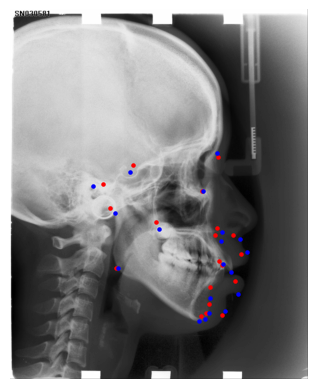

In [259]:
data = test_dataset[9]
image = data['image']
plot_output(image, model(image.unsqueeze(0).to(device)).cpu().detach(), data['landmarks'])